<a href="https://colab.research.google.com/github/Kaunaz/Assets/blob/master/notebooks/CA_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import random
import gdown
import shutil
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import plotly.graph_objs as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torchvision import models
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

datasets_info = {
    's':{
        'filename': 'small_dataset',
        'download_id': '1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF',
    },
    'm':{
        'filename': 'medium_dataset',
        'download_id': '1p06JpS-34-_4Ra5qmC19HWRxkHgctLjP'
    }
    # 'l':{ # TODO
}

In [2]:
DATASET='s' # 's' for small, 'm' for medium, 'l' for large
MODEL_NAME = 'CA-UNet' # CHANGE NAME

CHECKPOINT_STEP = 1
BATCH_SIZE = 64
MODELS_PATH = 'models'
RANDOM_SEED = 1

DEBUG = False

DATASET_INFO = datasets_info[DATASET]
DATASET_PATH = DATASET_INFO['filename'] # 'dataset' in VM
Path(MODELS_PATH).mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


PROCESSES = 16
WORKERS = os.cpu_count()


random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)


if DEBUG:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setup

## Dataset

### Download Dataset

In [3]:
# Check if dataset is already downloaded
if not os.path.exists(f'{DATASET_PATH}.tar.gz'):

    url = f'https://drive.google.com/uc?id={DATASET_INFO["download_id"]}'

    gdown.download(url, quiet=False)

    !tar -xf {DATASET_PATH}.tar.gz # CHANGE NAME
else:
    print(f'{DATASET_PATH}.tar.gz already downloaded')

Downloading...
From (original): https://drive.google.com/uc?id=1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF
From (redirected): https://drive.google.com/uc?id=1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF&confirm=t&uuid=dad08586-4766-490c-a9bb-0a7cc3f056f6
To: /content/small_dataset.tar.gz
100%|██████████| 798M/798M [00:12<00:00, 63.0MB/s]


### Dataset Utils

In [4]:
def filenames_per_map(folder, idx):
    idx_str = f"{idx:05d}"
    filenames = []

    for filename in os.listdir(folder):
        primera_parte, _ = filename.split('_')
        if primera_parte == idx_str:
            filenames.append(filename)

    return filenames


def maps(folder):
    filenames = os.listdir(folder)
    number_maps = [filename.split('_')[0] for filename in filenames]
    number_maps = map(int, number_maps)
    number_maps = sorted(list(set(number_maps)))
    return number_maps


def calculate_outliers(path, tol=2):
    image = np.load(path)

    max_val = np.max(image)
    min_val = np.min(image)

    if abs(min_val) > 2 or abs(max_val) > 2:
        return path


def calculate_outliers_dataset(folder_path, tol=2, filesave=False):
    os.listdir(folder_path)
    with Pool(PROCESSES) as pool:
        results = pool.starmap(calculate_outliers, [(os.path.join(folder_path, filename), tol) for filename in os.listdir(folder_path)])
    results =  [os.path.basename(result) for result in results if result is not None]

    if filesave:
        with open('outliers.txt', 'w') as f:
            for item in results:
                f.write("%s\n" % item)

    return results


def calculate_max_min(path):
    image = np.load(path)

    max_val = np.max(image)
    min_val = np.min(image)

    return np.array([max_val, min_val])


def calculate_max_min_dataset(folder_path, exclude_filename=None):
    if exclude_filename is not None:
        with open(exclude_filename, 'r') as f:
            exclude_filenames = f.read().splitlines()
    else:
        exclude_filenames = []

    filenames = [filename for filename in os.listdir(folder_path) if filename not in exclude_filenames]

    with Pool(PROCESSES) as pool:
        results = pool.map(calculate_max_min, [os.path.join(folder_path, filename) for filename in filenames])
    results = np.array(results)

    min_epsilon = results.min(axis=0)[1]
    max_epsilon = results.max(axis=0)[0]

    return min_epsilon, max_epsilon


def calculate_mean_std_image(path, channels=3):
    sum_means = np.zeros(channels)
    sum_stds = np.zeros(channels)

    image = np.load(path)
    mean_per_channel = np.mean(image, axis=(1, 2))
    std_per_channel = np.std(image, axis=(1, 2))

    sum_means += mean_per_channel
    sum_stds += std_per_channel


    return np.array([sum_means, sum_stds])


def calculate_mean_std_dataset(folder_path, channels=3):
    with Pool(PROCESSES) as pool:
        results = pool.starmap(calculate_mean_std_image, [(os.path.join(folder_path, filename), channels) for filename in os.listdir(folder_path)])
    results = np.array(results)
    results = np.mean(results, axis=0)
    return results

In [5]:
# mean_std = calculate_mean_std_dataset(os.path.join(DATASET_PATH, 'EPSILON'))
# min_max = calculate_max_min_dataset(os.path.join(DATASET_PATH, 'EPSILON'))

In [6]:
# dataset_means, dataset_stds = mean_std[0], mean_std[1]
# dataset_min, dataset_max = min_max

### Dataset Class

In [7]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, transform=None, transform_test=None):
        self.root_dir = root_dir
        self.transform = transform
        self.epsilon_dir = os.path.join(root_dir, 'EPSILON')
        self.kappa_dir = os.path.join(root_dir, 'KAPPA')

        self.epsilon_files = os.listdir(self.epsilon_dir)
        self.kappa_files = os.listdir(self.kappa_dir)

        self.epsilon_files.sort()
        self.kappa_files.sort()

    def __len__(self):
        return len(self.epsilon_files)


    def __getitem__(self, idx):
        epsilon_image_path = os.path.join(self.epsilon_dir, self.epsilon_files[idx])
        kappa_image_path = os.path.join(self.kappa_dir, self.kappa_files[idx])

        epsilon_image = np.load(epsilon_image_path)
        kappa_image = np.load(kappa_image_path)

        kappa_image = np.expand_dims(kappa_image, axis=0)

        epsilon_image = torch.from_numpy(epsilon_image).float()
        kappa_image = torch.from_numpy(kappa_image).float()

        if self.transform:
            epsilon_image = self.transform(epsilon_image)

        return epsilon_image, kappa_image

In [8]:
class BaselineAugmentation(object):
    def __init__(self):
        self.rotations = [0, 90, 180, 270]

    def __call__(self, x):
        angle = random.choice(self.rotations)
        x = v2.functional.rotate(x, angle)

        if random.random() > 0.5:
            x = v2.functional.hflip(x)
        if random.random() > 0.5:
            x = v2.functional.vflip(x)
        return x


class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, x):
        return torch.from_numpy(x).float()


class ReParameterize(object):
    def __init__(self):
        pass

    def __call__(self, epsilon):
        epsilon1 = epsilon[0, :, :]
        epsilon2 = epsilon[1, :, :]
        delta_epsilon = epsilon[2, :, :]

        magnitude_torch = torch.sqrt(epsilon1**2 + epsilon2**2)
        angle_torch = torch.atan2(epsilon2, epsilon1)

        reconstructed_epsilon = torch.stack([epsilon1, epsilon2, delta_epsilon, magnitude_torch, angle_torch], dim=0)
        return reconstructed_epsilon


class PreProcessing(object):
    def __call__(self, reconstructed_epsilon):
        magn = reconstructed_epsilon[3]

        magn = (magn - magn.min()) / (magn.max() - magn.min())

        hist = torch.histc(magn, bins=256, min=0, max=1)
        cdf = hist.cumsum(0)
        cdf = (cdf - cdf.min()) / (cdf.max() - cdf.min())
        magn = cdf[(magn * 255).long()] / 255.0

        magn = self.median_filter(magn, kernel_size=9)

        angle = self.median_filter(reconstructed_epsilon[4], kernel_size=7)

        magn_angle = torch.stack([magn, angle], dim=0)
        return torch.cat([reconstructed_epsilon[:3], magn_angle], dim=0)

    def median_filter(self, input_tensor, kernel_size):
        if input_tensor.dim() == 2:
            input_tensor = input_tensor.unsqueeze(0)

        padding = kernel_size // 2
        input_padded = F.pad(input_tensor, (padding, padding, padding, padding), mode='reflect')

        unfolded = input_padded.unfold(1, kernel_size, 1).unfold(2, kernel_size, 1)
        unfolded = unfolded.contiguous().view(unfolded.size(1), unfolded.size(2), -1)

        median_filtered = unfolded.median(dim=-1)[0]

        return median_filtered.squeeze(0)


# In the case of min-max normalization values must be (min, max),
# TODO: implement normalization per channel
# And in the case of standarization values must be (mean, std) where mean and
# std are arrays
class Normalize(object):
    def __init__(self, method='min_max', values=(-2,2)):
        self.method = method
        self.values = values

    def __call__(self, x):
        if self.method == 'min_max':
            min_value, max_value = self.values
            x = (x - min_value) / (max_value - min_value)
            return x
        elif self.method == 'standarization':
            mean, std = self.values
            x = v2.Normalize(mean=mean, std=std)(x)
            return x

### Dataset Loader

In [9]:
transform = v2.Compose([
    # Normalize(method='min_max', values=(dataset_min, dataset_max)),
    # Normalize(method='standarization', values=(dataset_means, dataset_stds)),
    ReParameterize(),
])

VM_TRAINING = False

lensing_dataset = LensingDataset(root_dir=DATASET_PATH, transform=None)

if VM_TRAINING:
    train_set, val_set = random_split(lensing_dataset, [0.80, 0.20]) # VM TRAINING
    train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(RANDOM_SEED), num_workers=WORKERS)
    val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
else:
    train_set, val_set, test_set = random_split(lensing_dataset, [0.75, 0.2, 0.05])
    train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(RANDOM_SEED), num_workers=WORKERS)
    val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
    test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=WORKERS)

In [10]:
train_loader.__len__(), val_loader.__len__(), test_loader.__len__() if test_loader else None

(88, 24, 371)

### Visualization

In [11]:
def plot_record(epsilon, kappa, show_axis=False, cmap=None):
    if show_axis:
        axis = 'on'
    else:
        axis = 'off'

    epsilon_vmin = np.min(epsilon)
    epsilon_vmax = np.max(epsilon)

    kappa_vmin = np.min(kappa)
    kappa_vmax = np.max(kappa)

    plt.figure(figsize=(12, 7))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplot(1, 4, 1)
    plt.imshow(epsilon[0], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Epsilon 1')
    plt.axis(axis)

    plt.subplot(1, 4, 2)
    plt.imshow(epsilon[1], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Epsilon 2')
    plt.axis(axis)

    plt.subplot(1, 4, 3)
    plt.imshow(epsilon[2], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Delta Epsilon')
    plt.axis(axis)

    plt.subplot(1, 4, 4)
    plt.imshow(kappa, vmin=kappa_vmin, vmax=kappa_vmax, cmap=cmap)
    plt.title('Kappa')
    plt.axis(axis)

    plt.show()


def plot_kappa(kappa_true, kappa_pred, show_axis=False, show_dpeaks=False, cmap=None):
    kt= kappa_true.astype(np.float32)
    kp= kappa_pred.astype(np.float32)
    if show_axis:
        axis = 'on'
        plt.figure(figsize=(7, 3))
    else:
        axis = 'off'
        plt.figure(figsize=(6, 3))

    if show_dpeaks:
        dpeaks_true = find_top_k_peaks(kt)
        dpeaks_pred = find_top_k_peaks(kp)
        dpeaks_true_x, dpeaks_true_y = dpeaks_true[:, 1], dpeaks_true[:, 0]
        dpeaks_pred_x, dpeaks_pred_y = dpeaks_pred[:, 1], dpeaks_pred[:, 0]

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplot(1, 2, 1)
    plt.imshow(kt, cmap=cmap)
    plt.title('Kappa True')
    if show_dpeaks:
        plt.scatter(dpeaks_true_x, dpeaks_true_y, color='red')
        for i in range(len(dpeaks_true_y)):
            plt.text(dpeaks_true_x[i], dpeaks_true_y[i], str(i + 1), fontsize=12, ha='right', va='bottom', color='red')

    plt.axis(axis)

    plt.subplot(1, 2, 2)
    plt.imshow(kp, cmap=cmap)
    plt.title('Kappa Prediction')
    if show_dpeaks:
        plt.scatter(dpeaks_pred_x, dpeaks_pred_y, color='red')
        for i in range(len(dpeaks_true_y)):
            plt.text(dpeaks_pred_x[i], dpeaks_pred_y[i], str(i + 1), fontsize=12, ha='right', va='bottom', color='red')
    plt.axis(axis)

    plt.show()

def intensity_histogram(image, range=(-0.5, 0.5)):
    plt.hist(image.flatten(), bins=200, alpha=0.6, label='Pred', color='orange', range=range)
    plt.legend(loc='upper right')
    plt.title('Histograma de Epsilon')
    plt.xlabel('Epsilon Value')
    plt.ylabel('Frequency')
    plt.show()

## Metrics

In [12]:
# WMAPE
def wmape_handcrafted(y_true : torch.Tensor, y_pred : torch.Tensor):
    W = 1 + (y_true / torch.max(y_true))

    y_true = torch.where(y_true == 0, torch.tensor(1e-7), y_true)
    randderecha = torch.abs(y_pred - y_true) / torch.abs(y_true)
    num = torch.sum(W * randderecha)

    denom = torch.sum(W)
    return (num / denom).item()

def wmape(T:torch.Tensor, P:torch.Tensor, delta = torch.tensor(1e-5)):
    T = torch.where(T == 0.0, delta, T)
    P = torch.where(P == 0.0, delta, P)
    W_fun = lambda T, max_T: 1 + (T/max_T)
    max_T = torch.max(T)
    W = W_fun(T, max_T)
    Numerator = W*(torch.abs(P-T)/torch.abs(T))
    sum_W = torch.sum(W)
    sum_Numerator = torch.sum(Numerator)
    return (sum_Numerator/sum_W).item()


# DICEE
def dicee_handcrafted(y_true: torch.Tensor, y_pred: torch.Tensor, alpha=0.5, beta=0.5):
    G = (y_true > torch.mean(y_true)).int()
    A = (y_pred > torch.mean(y_pred)).int()
    return (1 - torch.sum(G * A) / (torch.sum(G * A) + alpha * torch.sum((1 - G) * A) + beta * torch.sum((1 - A) * G))).item()

def DICE_binary_mask(Tensor:torch.tensor):
    Tensor_mask = Tensor - torch.mean(Tensor)
    Tensor_mask[torch.where(Tensor_mask > 0)] = 1
    Tensor_mask[torch.where(Tensor_mask <= 0)] = 0
    return Tensor_mask

def dicee(T:torch.Tensor, P:torch.Tensor, alpha:float = 0.5, beta:float = 0.5):
    if T.shape != P.shape: return None
    G = DICE_binary_mask(T)
    A = DICE_binary_mask(P)
    sum_G_A = torch.sum(G*A)
    sum_alpha = torch.sum(A*(1-G))
    sum_beta = torch.sum(G*(1-A))
    return (1-(sum_G_A/(sum_G_A + alpha*sum_alpha + beta*sum_beta))).item()


# DPEAKS
def find_top_k_peaks(im ,sigma=3, N=3):
    smoothed = gaussian_filter(im, sigma=sigma)
    coordinates = peak_local_max(smoothed,threshold_abs=None, num_peaks=N)
    while len(coordinates) < 3: coordinates = np.vstack([coordinates,np.array([0,0])])
    return coordinates

def official_dpeaks(T:np.ndarray, P:np.ndarray, num_peaks = 3):
    PEAKS_T = find_top_k_peaks(T, N=num_peaks)
    PEAKS_P = find_top_k_peaks(P, N=num_peaks)
    sum_DPEAKS = np.sum(np.abs(PEAKS_T-PEAKS_P))
    return sum_DPEAKS

def dpeaks(y_true : torch.Tensor, y_pred : torch.Tensor, num_peaks=3):
    y_true_np = y_true.cpu().numpy().astype(np.float32)
    y_pred_np = y_pred.cpu().numpy().astype(np.float32)

    dpeaks_sum = 0
    batch_size = y_true_np.shape[0]

    for i in range(batch_size):
        y_true_im = y_true_np[i].squeeze()
        y_pred_im = y_pred_np[i].squeeze()

        dpeaks_im = official_dpeaks(y_true_im, y_pred_im, num_peaks)
        dpeaks_sum += dpeaks_im

    return (dpeaks_sum / batch_size).item()

## Losses

In [13]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, y_true, y_pred):
        max_val = torch.max(y_true)
        weights = 1 + (torch.abs(y_true) / max_val)

        loss = weights * (y_pred - y_true) ** 2
        return torch.sum(loss)

class CombinedLoss(nn.Module):
    def __init__(self, WMSE_w= 0.3, dicee_w= 0.3, WMAPE_w= 0.3, dpeaks_w= 0.1):
        super(CombinedLoss, self).__init__()
        self.WMSE_loss = WeightedMSELoss()
        self.WMSE_w =  WMSE_w
        self.dicee_w = dicee_w
        self.WMAPE_w = WMAPE_w
        self.dpeaks_w = dpeaks_w

    def forward(self, y_true, y_pred):
        y_pred_detach=y_pred.detach()
        y_true_detach=y_true.detach()

        WMSE_loss = self.WMSE_loss(y_true, y_pred)
        dicee_loss = dicee(y_true_detach, y_pred_detach)
        WMAPE_loss = wmape(y_true_detach, y_pred_detach)
        dpeaks_loss = dpeaks(y_true_detach, y_pred_detach)

        return (WMSE_loss*self.WMSE_w + dicee_loss*self.dicee_w + WMAPE_loss*self.WMAPE_w + dpeaks_loss*self.dpeaks_w)


class SSIM_Loss(nn.Module):
    def __init__(self, max_val=1.0, win_size=7):
        super(SSIM_Loss, self).__init__()
        self.max_val = max_val
        self.win_size = win_size

    def forward(self, pred, target):
        pred_min, pred_max = pred.min(), pred.max()
        target_min, target_max = target.min(), target.max()

        pred_range = pred_max - pred_min
        target_range = target_max - target_min

        pred_range = max(pred_range.item(), 1e-5)
        target_range = max(target_range.item(), 1e-5)

        pred = (pred - pred_min) / pred_range
        target = (target - target_min) / target_range

        ssim_value = ssim(pred, target, data_range=self.max_val, size_average=True, win_size=self.win_size)
        ssim_value = torch.clamp(ssim_value, 0, 1)

        loss = 1 - ssim_value
        return loss

## Training functions

In [14]:
def save_checkpoint(model, optimizer, epoch, history, filepath='checkpoint.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'history': history,
        'random_state': {
            'python': random.getstate(),
            'numpy': np.random.get_state(),
            'torch': torch.get_rng_state(),
            'torch_cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
        }
    }
    torch.save(checkpoint, filepath)
    print(f'Checkpoint saved to {filepath}\n')


def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    history = checkpoint['history']

    random.setstate(checkpoint['random_state']['python'])
    np.random.set_state(checkpoint['random_state']['numpy'])
    torch.set_rng_state(checkpoint['random_state']['torch'])
    if torch.cuda.is_available() and checkpoint['random_state']['torch_cuda'] is not None:
        torch.cuda.set_rng_state_all(checkpoint['random_state']['torch_cuda'])

    return model, optimizer, epoch, history

In [15]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, start_epoch=None, metrics=None, scheduler=None, device='cuda'):

    history = {
        'train_losses': [],
        'val_losses': [],
        }

    if metrics is not None:
        for metric_name in metrics.keys():
            history[f'train_{metric_name}'] = []
            history[f'val_{metric_name}'] = []

    if scheduler is not None:
        history['lr'] = []

    if start_epoch is None:
        start_epoch = 1

    if start_epoch > epochs:
        raise ValueError("start_epoch must be less than or equal to epochs")

    for epoch in range(start_epoch, epochs + 1):
        model.train()

        train_p_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        epoch_train_loss = 0
        epoch_val_loss = 0

        if metrics is not None:
            epoch_train_metrics = {metric_name: 0 for metric_name in metrics.keys()}
            epoch_val_metrics = {metric_name: 0 for metric_name in metrics.keys()}


        for _, (epsilon, kappa) in train_p_bar:
            epsilon, kappa = epsilon.to(device), kappa.to(device)

            optimizer.zero_grad()

            y_hat = model(epsilon)
            loss = criterion(kappa, y_hat)
            loss.backward()
            optimizer.step()

            batch_size = epsilon.size(0)

            epoch_train_loss += loss.item() * batch_size

            kappa_detached = kappa.detach().cpu()
            y_hat_detached = y_hat.detach().cpu()
            if metrics is not None:
                for metric_name, metric_fn in metrics.items():
                    metric_value = metric_fn(kappa_detached, y_hat_detached)
                    epoch_train_metrics[metric_name] += metric_value * batch_size

            train_p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")


        epoch_train_loss /= len(train_loader.dataset)
        history['train_losses'].append(epoch_train_loss)

        if metrics is not None:
            for metric_name in metrics.keys():
                epoch_train_metrics[metric_name] /= len(train_loader.dataset)
                history[f'train_{metric_name}'].append(epoch_train_metrics[metric_name])

            train_metrics_formatted = ', '.join([f"{metric_name}: {epoch_train_metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
            print(f"Train Metrics: Loss: {epoch_train_loss:.4f}, {train_metrics_formatted}")

        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN in gradients of layer {name}")

        model.eval()
        with torch.inference_mode():
            val_p_bar = tqdm(enumerate(val_loader), total=len(val_loader))
            for _, (epsilon, kappa) in val_p_bar:
                epsilon, kappa = epsilon.to(device), kappa.to(device)
                y_hat = model(epsilon)
                loss = criterion(kappa, y_hat)

                batch_size = epsilon.size(0)

                epoch_val_loss += loss.item() * batch_size

                kappa_detached = kappa.detach()
                y_hat_detached = y_hat.detach()
                if metrics is not None:
                    for metric_name, metric_fn in metrics.items():
                        metric_value = metric_fn(kappa_detached, y_hat_detached)
                        epoch_val_metrics[metric_name] += metric_value * batch_size

                val_p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")

        epoch_val_loss /= len(val_loader.dataset)
        history['val_losses'].append(epoch_val_loss)

        if scheduler is not None:
            scheduler.step(epoch_val_loss)
            history["lr"].append(scheduler.get_last_lr())


        if metrics is not None:
            for metric_name in metrics.keys():
                epoch_val_metrics[metric_name] /= len(val_loader.dataset)
                history[f'val_{metric_name}'].append(epoch_val_metrics[metric_name])

            val_metrics_formatted = ', '.join([f"{metric_name}: {epoch_val_metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
            print(f"Val Metrics: Loss: {epoch_val_loss:.4f}, {val_metrics_formatted}, Actual lr: {scheduler.get_last_lr() if scheduler is not None else None}")


        if epoch % CHECKPOINT_STEP == 0:
            save_checkpoint(model, optimizer, epoch, history, os.path.join(MODELS_PATH, f'{MODEL_NAME}_model_{epoch}E.pth'))
        else:
            print('\n')
    return history


In [16]:
def evaluate(model: nn.Module,
             test_loader: torch.utils.data.DataLoader,
             criterion: torch.nn.Module,
             epoch: int,
             epochs: int,
             metrics: dict,
             device: torch.device):

    metrics = {metric_name: 0 for metric_name in metrics.keys()}
    total_loss = 0

    model.eval()
    with torch.inference_mode():
        p_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for _, (epsilon, kappa) in p_bar:
            epsilon, kappa = epsilon.to(device), kappa.to(device)
            y_hat = model(epsilon)
            loss = criterion(y_hat, kappa)

            batch_size = epsilon.size(0)

            total_loss += loss.item() * batch_size

            kappa_detached = kappa.detach()
            y_hat_detached = y_hat.detach()

            for metric_name, metric_fn in metrics.items():
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                metrics[metric_name] += metric_value * batch_size

            p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(test_loader.dataset)
    metrics_formatted = ', '.join([f"{metric_name}: {metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
    print(f"Evaluation Metrics: Loss: {avg_loss:.4f}, {metrics_formatted}")

    return avg_loss, metrics

# Model

## Blocks

In [17]:
print(torch.__version__)

# Install natten for torch version: 2.4.0+cu121
!pip3 install natten==0.17.1+torch240cu121 -f https://shi-labs.com/natten/wheels/

2.4.1+cu121
Looking in links: https://shi-labs.com/natten/wheels/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.4/473.4 MB 3.6 MB/s eta 0:00:00


In [18]:
class DWiseConv2d(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1, padding=0, bias=False):
        super(DWiseConv2d, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels=in_channels,
                                        out_channels=in_channels,  # Same as input channels
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=padding,
                                        groups=in_channels,  # Depthwise convolution
                                        bias=bias)

    def forward(self, x):
        return self.depthwise_conv(x)

class PWiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, bias=False):
        super(PWiseConv2d, self).__init__()
        self.pointwise_conv = nn.Conv2d(in_channels=in_channels,
                                        out_channels=out_channels,
                                        kernel_size=1,
                                        stride=stride,
                                        bias=bias)

    def forward(self, x):
        return self.pointwise_conv(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride= 1, padding= 0):
        super(ConvBlock, self).__init__()

        self.padding= (kernel_size-1) // 2

        self.dwise1= nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, padding=self.padding)
        self.bn= nn.InstanceNorm2d(in_channels)
        self.pwise1= nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.activation= nn.GELU()
        self.pwise2= nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.dwise2= nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, groups=out_channels, padding=self.padding)

    def forward(self, x):
        x= self.dwise1(x)
        x= self.bn(x)
        x= self.pwise1(x)
        x= self.activation(x)
        x= self.pwise2(x)
        x= self.dwise2(x)
        x= self.activation(x)
        return x



class CoordinateAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.InstanceNorm2d(in_channels)
        self.act = nn.ReLU(inplace=True)
        self.conv_h = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        identity = x
        b,c,h,w = x.shape
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).transpose(-1, -2)
        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)
        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.transpose(-1, -2)
        a_h = self.conv_h(x_h)
        a_w = self.conv_w(x_w)
        out = identity * a_h * a_w
        return out

from natten.functional import na2d_qk, na2d_av
class NeighborhoodAttention2D(nn.Module):
    def __init__(self, dim, kernel_size=3, num_heads=4, qkv_bias=True, proj_drop=0.0, attn_drop_rate=0.0):
        super(NeighborhoodAttention2D, self).__init__()

        self.num_heads = num_heads
        self.head_dim = dim // self.num_heads
        self.scale = self.head_dim**-0.5
        self.kernel_size = kernel_size

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)

        self.attn_drop_rate = attn_drop_rate
        self.attn_drop = nn.Dropout(self.attn_drop_rate)

        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        # input: B, H, W, C

        B, H, W, C = x.shape

        qkv = self.qkv(x).reshape(B, H, W, 3, self.num_heads, self.head_dim).permute(3, 0, 4, 1, 2, 5)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale

        attn = na2d_qk(
            q,
            k,
            kernel_size=self.kernel_size,
            dilation=1,
            is_causal=False,
            rpb=None,
        )
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = na2d_av(
            attn,
            v,
            kernel_size=self.kernel_size,
            dilation=1,
            is_causal=False,
        )
        x = x.permute(0, 2, 3, 1, 4).reshape(B, H, W, C)

        return self.proj_drop(self.proj(x)) # B, H, W, C

class MLP(nn.Module):
    def __init__(self, in_channels, mlp_channels):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_channels, mlp_channels)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(mlp_channels, in_channels)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.fc2(x)
        return x

class NAT2DLayer(nn.Module):
    def __init__(self, in_channels, kernel_size=3, num_heads=4, img_size=128):
        super(NAT2DLayer, self).__init__()
        # TODO: Scale kernel size depending on layer depth
        self.ln1 = nn.LayerNorm(in_channels)
        self.mhna = NeighborhoodAttention2D(dim=in_channels, kernel_size=kernel_size, num_heads=num_heads)

        self.ln2 = nn.LayerNorm(in_channels) # B, H, W, C
        self.mlp = MLP(in_channels=in_channels, mlp_channels=in_channels) # B, H * W, C

    def forward(self, x):
        # input: B, C, W, H
        x = x.permute(0, 3, 2, 1) # B, C, W, H -> B, H, W, C

        x = x + self.mhna(self.ln1(x))
        x = x + self.mlp(self.ln2(x))

        return x.permute(0, 3, 2, 1) # B, H, W, C -> B, C, W, H

class Down(nn.Module):
    def __init__(self, in_channels, out_channels=None, img_size=128):
        super(Down, self).__init__()
        if out_channels is None:
            out_channels = in_channels
        self.conv_block = ConvBlock(in_channels=in_channels, out_channels=out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.ca = CoordinateAttention(in_channels=out_channels)

    def forward(self, x):
        s = self.conv_block(x)
        x = self.maxpool(s)
        x = self.ca(x)
        return x, s

class Up(nn.Module):
    def __init__(self, in_channels, scale_spatial_dim=True):
        super(Up, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels=in_channels*2,
                                          out_channels=in_channels,
                                          kernel_size=2,
                                          stride=2) if scale_spatial_dim else nn.Identity()
        # TODO: Implement upsample from original UNet instead of ConvTranspose2d
        #self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        if not scale_spatial_dim:
            in_channels = in_channels*2

        # if scale_spatial_dim:
        #     img_size = img_size*2
        # else:
        #     in_channels = in_channels*2

        self.ca = CoordinateAttention(in_channels=in_channels) # TODO: Fix this
        self.conv_block = ConvBlock(in_channels=in_channels, out_channels=in_channels//2)

    def forward(self, x, skip):
        x = torch.cat([x, skip], dim=1)
        x = self.upconv(x)
        x = self.ca(x)
        x = self.conv_block(x)
        return x



#model = ConvBlock(in_channels=3, out_channels=64)
#model = CoordinateAttention(in_channels=32)
#model = NeighborhoodAttention2D(dim=32, kernel_size=3, num_heads=4)
#model = NeighborhoodAttention1D(dim=512, kernel_size=3, num_heads=4)
#model = MLP(in_channels=512, mlp_channels=512)
#model = NATLayer(in_channels=512, kernel_size=3)
#model = Patchify(in_channels=3, hidden_dim=512, patch_size=16)
#model = Down(in_channels=3, out_channels=32, img_size=128)
#model = Up(in_channels=32, img_size=128, scale_spatial_dim=True)
#model = NAT2DLayer(in_channels=32, kernel_size=3, num_heads=4, img_size=128)

# summary(model, [(1, 64, 512)], col_names=("input_size", "output_size", "num_params"))
#summary(model, [(1, 3, 128, 128)], col_names=("input_size", "output_size", "num_params"))
#summary(model, [(1, 32, 128, 128), (1, 32, 128, 128)], col_names=("input_size", "output_size", "num_params"))

/usr/local/lib/python3.10/dist-packages/natten/functional.py:83: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/natten/functional.py:205: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(
/usr/local/lib/python3.10/dist-packages/natten/functional.py:261: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/usr/local/lib/python3.10/dist-packages/natten/functional.py:381: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(
/usr/local/lib/python3.10/dist-packages/natten/functional.py:426: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` i

## Model

In [19]:
# class CAUNet(nn.Module):
#     def __init__(self, in_channels, features=[32, 64, 128, 256], patch_size=16, img_size=128):
#         super(CAUNet, self).__init__()

#         # Down Layers
#         self.down1 = Down(in_channels=in_channels, out_channels=features[0], img_size=img_size)
#         self.nat1 = NAT2DLayer(in_channels=features[0], kernel_size=3, img_size=img_size)

#         self.down2 = Down(in_channels=features[0], out_channels=features[1], img_size=img_size//2)
#         self.nat2 = NAT2DLayer(in_channels=features[1], kernel_size=3, img_size=img_size//2)

#         self.down3 = Down(in_channels=features[1], out_channels=features[2], img_size=img_size//4)
#         self.nat3 = NAT2DLayer(in_channels=features[2], kernel_size=3, img_size=img_size//4)

#         self.down4 = Down(in_channels=features[2], out_channels=features[3], img_size=img_size//8)
#         self.nat4 = NAT2DLayer(in_channels=features[3], kernel_size=3, img_size=img_size//8)

#         # Bottleneck
#         self.bottleneck = ConvBlock(in_channels=features[3], out_channels=features[3], kernel_size=7, stride=1, padding=0)
#         self.upconv = nn.ConvTranspose2d(in_channels=features[3],
#                                           out_channels=features[3],
#                                           kernel_size=2,
#                                           stride=2)
#         # TODO: Implement upsample from original UNet instead of ConvTranspose2d
#         #self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.ca = CoordinateAttention(in_channels=features[3])

#         # Up Layers
#         self.up1 = Up(in_channels=features[3])
#         self.up2 = Up(in_channels=features[2])
#         self.up3 = Up(in_channels=features[1])
#         self.up4 = Up(in_channels=features[0], scale_spatial_dim=False)

#         self.out_conv = nn.Sequential(
#                             nn.Conv2d(in_channels=features[0], out_channels=1, kernel_size=1)
#                             #nn.Tanh()
#                             #nn.Sigmoid()
#         )




#     def forward(self, x):
#         d1, s1 = self.down1(x)
#         n1 = self.nat1(s1)

#         d2, s2 = self.down2(d1)
#         n2 = self.nat2(s2)

#         d3, s3 = self.down3(d2)
#         n3 = self.nat3(s3)

#         d4, s4 = self.down4(d3)
#         n4 = self.nat4(s4)

#         b = self.bottleneck(d4)
#         b = self.upconv(b) # TODO: check this Weird UpConv
#         b = self.ca(b)

#         u1 = self.up1(b, n4)
#         u2 = self.up2(u1, n3)
#         u3 = self.up3(u2, n2)
#         u4 = self.up4(u3, n1)

#         out = self.out_conv(u4)

#         return out

# model = CAUNet(in_channels=3, features=[32, 64, 128, 256, 512])
# summary(model, [(1, 3, 128, 128)], col_names=("input_size", "output_size", "num_params"))

In [20]:
class CAUNet(nn.Module):
    def __init__(self, in_channels, features=[32, 64, 128, 256], patch_size=16, img_size=128):
        super(CAUNet, self).__init__()

        self.downs= nn.ModuleList()
        self.nats= nn.ModuleList()

        for i in range(len(features)):
            self.downs.append(Down(in_channels=in_channels if i == 0 else features[i-1], out_channels=features[i]))
            self.nats.append(NAT2DLayer(in_channels=features[i], kernel_size=3))

        # Bottleneck
        self.bottleneck = ConvBlock(in_channels=features[-1], out_channels=features[-1], kernel_size=7, stride=1, padding=0)
        self.upconv = nn.ConvTranspose2d(in_channels=features[-1],
                                          out_channels=features[-1],
                                          kernel_size=2,
                                          stride=2)
        # TODO: Implement upsample from original UNet instead of ConvTranspose2d
        #self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.ca = CoordinateAttention(in_channels=features[-1])

        self.ups = nn.ModuleList()
        for i in range(len(features) - 1, 0, -1):
            self.ups.append(Up(in_channels=features[i]))

        self.up_final = Up(in_channels=features[0], scale_spatial_dim=False)


        self.out_conv = nn.Sequential(
                            nn.Conv2d(in_channels=features[0], out_channels=1, kernel_size=1)
                            #nn.Tanh()
                            #nn.Sigmoid()
        )




    def forward(self, x):

        skip_connections = []
        for down, nat in zip(self.downs, self.nats):
            x, skip = down(x)
            skip_connections.append(nat(skip))

        b= self.bottleneck(x)
        b= self.upconv(b)
        b= self.ca(b)

        for up, skip in zip(self.ups, reversed(skip_connections[1:])):
            b= up(b, skip)

        u_f = self.up_final(b, skip_connections[0])

        out = self.out_conv(u_f)

        return out

model = CAUNet(in_channels=3, features=[32, 64, 128, 256])
summary(model, [(1, 3, 128, 128)], col_names=("input_size", "output_size", "num_params"))

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
CAUNet                                        [1, 3, 128, 128]          [1, 1, 128, 128]          --
├─ModuleList: 1-7                             --                        --                        (recursive)
│    └─Down: 2-1                              [1, 3, 128, 128]          [1, 32, 64, 64]           --
│    │    └─ConvBlock: 3-1                    [1, 3, 128, 128]          [1, 32, 128, 128]         2,934
│    │    └─MaxPool2d: 3-2                    [1, 32, 128, 128]         [1, 32, 64, 64]           --
│    │    └─CoordinateAttention: 3-3          [1, 32, 64, 64]           [1, 32, 64, 64]           3,168
├─ModuleList: 1-8                             --                        --                        (recursive)
│    └─NAT2DLayer: 2-2                        [1, 32, 128, 128]         [1, 32, 128, 128]         --
│    │    └─LayerNorm: 3-4                    [1, 128, 128, 32

# Training

## Scheduler

In [21]:
INITIAL_LR = 0.00001
TARGET_LR = 0.0001
WARMUP_EPOCHS = 10
EPOCHS = 50

def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return (TARGET_LR / INITIAL_LR) * (epoch / WARMUP_EPOCHS)
    return 1

# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

# scheduler = lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.1,
#     patience=5,
#     threshold=0.01,
#     min_lr=1e-6
# )

## Train

In [22]:
model = CAUNet(in_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)

criterion = CombinedLoss(WMSE_w = 1, dicee_w = 100, WMAPE_w = 50, dpeaks_w = 1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)

EPOCHS = 50

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    threshold=0.01,
    min_lr=1e-6
)

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

print(f'Training parameters: \nModel: {MODEL_NAME}\nEpochs: {EPOCHS}\nMetrics: {list(metrics.keys())}\nDevice: {DEVICE}\nScheduler: {scheduler.__class__.__name__}\n' +
      f'Criterion: {criterion.__class__.__name__}\nOptimizer: {optimizer}\n')

Training parameters: 
Model: CA-UNet
Epochs: 50
Metrics: ['wmape', 'dicee', 'dpeaks']
Device: cpu
Scheduler: ReduceLROnPlateau
Criterion: CombinedLoss
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.001
)



In [ ]:
RESUME_TRAINING = False
CHECKPOINT_FILEPATH = os.path.join(MODELS_PATH, 'basic_CNN_model_1E.pth')

if RESUME_TRAINING:
    model, optimizer, last_epoch, history = load_checkpoint(model, optimizer, CHECKPOINT_FILEPATH)

# TODO: integrate history

In [ ]:
history = train(
    model, train_loader, val_loader,
    criterion, optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    metrics=metrics,
    device=DEVICE,
    start_epoch=(last_epoch+1) if RESUME_TRAINING else None)

Epoch: 1/50, Loss: 358.0104: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 2360.1031, wmape: 6.1115, dicee: 0.4207, dpeaks: 170.9399



Epoch: 1/50, Loss: 545.3339: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


Val Metrics: Loss: 1263.1683, wmape: 4.7190, dicee: 0.3658, dpeaks: 148.4458, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_1E.pth



Epoch: 2/50, Loss: 266.6179: 100%|██████████| 88/88 [02:21<00:00,  1.61s/it]

Train Metrics: Loss: 1152.3326, wmape: 4.7096, dicee: 0.3337, dpeaks: 140.8086



Epoch: 2/50, Loss: 514.6310: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 1177.3560, wmape: 4.1469, dicee: 0.3232, dpeaks: 136.9825, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_2E.pth



Epoch: 3/50, Loss: 463.6996: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]


Train Metrics: Loss: 1097.5451, wmape: 4.6567, dicee: 0.3174, dpeaks: 137.0986


Epoch: 3/50, Loss: 448.3766: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Val Metrics: Loss: 1019.9465, wmape: 4.0119, dicee: 0.3074, dpeaks: 129.1677, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_3E.pth



Epoch: 4/50, Loss: 433.3257: 100%|██████████| 88/88 [02:21<00:00,  1.60s/it]

Train Metrics: Loss: 1053.9595, wmape: 4.6472, dicee: 0.3035, dpeaks: 134.5147



Epoch: 4/50, Loss: 571.6420: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


Val Metrics: Loss: 1162.0939, wmape: 5.0191, dicee: 0.3019, dpeaks: 127.4694, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_4E.pth



Epoch: 5/50, Loss: 453.3418: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 1022.4394, wmape: 4.6158, dicee: 0.2965, dpeaks: 131.6452



Epoch: 5/50, Loss: 624.1169: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


Val Metrics: Loss: 1255.6774, wmape: 5.8327, dicee: 0.2904, dpeaks: 128.0855, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_5E.pth



Epoch: 6/50, Loss: 310.3850: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 1029.2609, wmape: 4.6550, dicee: 0.2954, dpeaks: 130.0052



Epoch: 6/50, Loss: 487.6826: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


Val Metrics: Loss: 989.8106, wmape: 4.5264, dicee: 0.2889, dpeaks: 127.5886, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_6E.pth



Epoch: 7/50, Loss: 341.3595: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 969.2905, wmape: 4.5528, dicee: 0.2843, dpeaks: 127.8291



Epoch: 7/50, Loss: 578.6998: 100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


Val Metrics: Loss: 1119.9463, wmape: 5.1832, dicee: 0.2825, dpeaks: 120.9407, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_7E.pth



Epoch: 8/50, Loss: 378.3784: 100%|██████████| 88/88 [02:22<00:00,  1.61s/it]

Train Metrics: Loss: 869.6242, wmape: 4.4931, dicee: 0.2582, dpeaks: 113.5145



Epoch: 8/50, Loss: 427.7237: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


Val Metrics: Loss: 828.8171, wmape: 4.4709, dicee: 0.2456, dpeaks: 104.1758, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_8E.pth



Epoch: 9/50, Loss: 276.7693: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 713.5295, wmape: 4.2149, dicee: 0.2210, dpeaks: 97.8020



Epoch: 9/50, Loss: 468.8616: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


Val Metrics: Loss: 969.1191, wmape: 4.9331, dicee: 0.2216, dpeaks: 94.1751, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_9E.pth



Epoch: 10/50, Loss: 309.4514: 100%|██████████| 88/88 [02:21<00:00,  1.61s/it]

Train Metrics: Loss: 691.9316, wmape: 4.1420, dicee: 0.2121, dpeaks: 94.0368



Epoch: 10/50, Loss: 340.1407: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


Val Metrics: Loss: 604.7723, wmape: 3.7610, dicee: 0.2011, dpeaks: 86.4236, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_10E.pth



Epoch: 11/50, Loss: 220.5361: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 610.0277, wmape: 3.9043, dicee: 0.1947, dpeaks: 87.8104



Epoch: 11/50, Loss: 347.4608: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


Val Metrics: Loss: 632.2637, wmape: 4.0290, dicee: 0.1949, dpeaks: 86.7987, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_11E.pth



Epoch: 12/50, Loss: 439.7435: 100%|██████████| 88/88 [02:23<00:00,  1.64s/it]

Train Metrics: Loss: 585.1815, wmape: 3.8501, dicee: 0.1887, dpeaks: 85.3759



Epoch: 12/50, Loss: 397.2197: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


Val Metrics: Loss: 726.8109, wmape: 4.5805, dicee: 0.1930, dpeaks: 88.0027, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_12E.pth



Epoch: 13/50, Loss: 166.8603: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 584.6823, wmape: 3.8661, dicee: 0.1843, dpeaks: 84.0275



Epoch: 13/50, Loss: 369.4767: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


Val Metrics: Loss: 667.9407, wmape: 4.3702, dicee: 0.1917, dpeaks: 81.4532, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_13E.pth



Epoch: 14/50, Loss: 205.3915: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Metrics: Loss: 574.5181, wmape: 3.8473, dicee: 0.1808, dpeaks: 83.0842


Epoch: 14/50, Loss: 349.2103: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Val Metrics: Loss: 599.1875, wmape: 3.6922, dicee: 0.1932, dpeaks: 85.9556, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_14E.pth



Epoch: 15/50, Loss: 429.0878: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 536.4774, wmape: 3.6694, dicee: 0.1736, dpeaks: 83.2849



Epoch: 15/50, Loss: 300.1588: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Val Metrics: Loss: 500.6183, wmape: 3.4267, dicee: 0.1743, dpeaks: 76.7313, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_15E.pth



Epoch: 16/50, Loss: 159.0367: 100%|██████████| 88/88 [02:21<00:00,  1.61s/it]

Train Metrics: Loss: 513.6334, wmape: 3.5855, dicee: 0.1683, dpeaks: 78.0619



Epoch: 16/50, Loss: 321.5569: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Val Metrics: Loss: 576.5912, wmape: 3.8508, dicee: 0.1706, dpeaks: 75.8842, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_16E.pth



Epoch: 17/50, Loss: 177.0045: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 485.0600, wmape: 3.4983, dicee: 0.1622, dpeaks: 75.2465



Epoch: 17/50, Loss: 368.1125: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 664.5577, wmape: 4.1417, dicee: 0.1667, dpeaks: 76.5886, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_17E.pth



Epoch: 18/50, Loss: 348.5298: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 495.4347, wmape: 3.5110, dicee: 0.1620, dpeaks: 76.2950



Epoch: 18/50, Loss: 263.4496: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Val Metrics: Loss: 458.9927, wmape: 3.2339, dicee: 0.1634, dpeaks: 72.7071, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_18E.pth



Epoch: 19/50, Loss: 295.6927: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 463.9886, wmape: 3.4128, dicee: 0.1559, dpeaks: 73.2065



Epoch: 19/50, Loss: 257.6121: 100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


Val Metrics: Loss: 455.9622, wmape: 2.9028, dicee: 0.1572, dpeaks: 73.2923, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_19E.pth



Epoch: 20/50, Loss: 164.7170: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 466.3063, wmape: 3.4188, dicee: 0.1536, dpeaks: 72.4348



Epoch: 20/50, Loss: 268.7425: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Val Metrics: Loss: 491.3483, wmape: 3.0997, dicee: 0.1718, dpeaks: 76.3879, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_20E.pth



Epoch: 21/50, Loss: 215.7440: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 469.5611, wmape: 3.4170, dicee: 0.1562, dpeaks: 73.6616



Epoch: 21/50, Loss: 251.0772: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 449.1927, wmape: 3.0788, dicee: 0.1572, dpeaks: 75.4768, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_21E.pth



Epoch: 22/50, Loss: 115.1527: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 453.5603, wmape: 3.3325, dicee: 0.1499, dpeaks: 71.7074



Epoch: 22/50, Loss: 484.8033: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


Val Metrics: Loss: 940.3263, wmape: 6.1016, dicee: 0.1551, dpeaks: 69.9751, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_22E.pth



Epoch: 23/50, Loss: 309.1743: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 455.1570, wmape: 3.3259, dicee: 0.1508, dpeaks: 71.9047



Epoch: 23/50, Loss: 487.9192: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 867.3027, wmape: 5.2711, dicee: 0.1538, dpeaks: 73.7502, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_23E.pth



Epoch: 24/50, Loss: 135.4094: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 530.9656, wmape: 3.6209, dicee: 0.1680, dpeaks: 78.3838



Epoch: 24/50, Loss: 249.2255: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Val Metrics: Loss: 476.9099, wmape: 3.2351, dicee: 0.1555, dpeaks: 73.6707, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_24E.pth



Epoch: 25/50, Loss: 119.9231: 100%|██████████| 88/88 [02:21<00:00,  1.60s/it]

Train Metrics: Loss: 424.6830, wmape: 3.2095, dicee: 0.1448, dpeaks: 70.2964



Epoch: 25/50, Loss: 259.2369: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


Val Metrics: Loss: 400.9211, wmape: 2.9833, dicee: 0.1446, dpeaks: 68.0162, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_25E.pth



Epoch: 26/50, Loss: 300.6500: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 428.6803, wmape: 3.2540, dicee: 0.1418, dpeaks: 68.6944



Epoch: 26/50, Loss: 311.6082: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Val Metrics: Loss: 568.9214, wmape: 3.5323, dicee: 0.1624, dpeaks: 72.0963, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_26E.pth



Epoch: 27/50, Loss: 281.6279: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 413.8447, wmape: 3.1453, dicee: 0.1405, dpeaks: 69.1440



Epoch: 27/50, Loss: 395.9599: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Val Metrics: Loss: 719.9404, wmape: 4.5953, dicee: 0.1485, dpeaks: 71.4094, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_27E.pth



Epoch: 28/50, Loss: 145.2737: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 435.5361, wmape: 3.2331, dicee: 0.1442, dpeaks: 71.5740



Epoch: 28/50, Loss: 278.0710: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 398.1722, wmape: 3.0170, dicee: 0.1413, dpeaks: 70.5845, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_28E.pth



Epoch: 29/50, Loss: 163.5970: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 396.1761, wmape: 3.0885, dicee: 0.1351, dpeaks: 67.7943



Epoch: 29/50, Loss: 496.2667: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Val Metrics: Loss: 939.0246, wmape: 5.9176, dicee: 0.1519, dpeaks: 70.7919, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_29E.pth



Epoch: 30/50, Loss: 161.3762: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 436.9449, wmape: 3.2750, dicee: 0.1426, dpeaks: 69.6469



Epoch: 30/50, Loss: 324.2662: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


Val Metrics: Loss: 496.1963, wmape: 3.4021, dicee: 0.1423, dpeaks: 66.1071, Actual lr: [0.01]
Checkpoint saved to models/CA-UNet_model_30E.pth



Epoch: 31/50, Loss: 304.8346: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 406.3029, wmape: 3.1056, dicee: 0.1362, dpeaks: 68.6745



Epoch: 31/50, Loss: 385.1654: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Val Metrics: Loss: 640.4490, wmape: 4.3341, dicee: 0.1401, dpeaks: 69.4236, Actual lr: [0.001]
Checkpoint saved to models/CA-UNet_model_31E.pth



Epoch: 32/50, Loss: 199.8908: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 354.8538, wmape: 2.8495, dicee: 0.1254, dpeaks: 64.2840



Epoch: 32/50, Loss: 259.4576: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 366.9650, wmape: 2.8178, dicee: 0.1355, dpeaks: 65.5259, Actual lr: [0.001]
Checkpoint saved to models/CA-UNet_model_32E.pth



Epoch: 33/50, Loss: 152.2874: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 328.8521, wmape: 2.6941, dicee: 0.1215, dpeaks: 62.9237



Epoch: 33/50, Loss: 251.1798: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 360.0475, wmape: 2.7337, dicee: 0.1345, dpeaks: 65.3872, Actual lr: [0.001]
Checkpoint saved to models/CA-UNet_model_33E.pth



Epoch: 34/50, Loss: 200.7385: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 324.1130, wmape: 2.6590, dicee: 0.1201, dpeaks: 62.1501



Epoch: 34/50, Loss: 264.0120: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 364.8572, wmape: 2.8113, dicee: 0.1344, dpeaks: 65.2822, Actual lr: [0.001]
Checkpoint saved to models/CA-UNet_model_34E.pth



Epoch: 35/50, Loss: 126.7644: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 320.5679, wmape: 2.6319, dicee: 0.1188, dpeaks: 62.6129



Epoch: 35/50, Loss: 270.2707: 100%|██████████| 24/24 [00:17<00:00,  1.40it/s]


Val Metrics: Loss: 371.0344, wmape: 2.8791, dicee: 0.1348, dpeaks: 65.1077, Actual lr: [0.001]
Checkpoint saved to models/CA-UNet_model_35E.pth



Epoch: 36/50, Loss: 146.7852: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 317.6801, wmape: 2.6157, dicee: 0.1176, dpeaks: 62.5311



Epoch: 36/50, Loss: 258.8593: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Val Metrics: Loss: 365.7970, wmape: 2.8481, dicee: 0.1345, dpeaks: 64.2761, Actual lr: [0.001]
Checkpoint saved to models/CA-UNet_model_36E.pth



Epoch: 37/50, Loss: 153.5859: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 314.7852, wmape: 2.5954, dicee: 0.1167, dpeaks: 62.6268



Epoch: 37/50, Loss: 262.1559: 100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


Val Metrics: Loss: 370.7134, wmape: 2.8871, dicee: 0.1348, dpeaks: 64.3407, Actual lr: [0.001]
Checkpoint saved to models/CA-UNet_model_37E.pth



Epoch: 38/50, Loss: 159.2819: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 312.2150, wmape: 2.5696, dicee: 0.1156, dpeaks: 62.9851



Epoch: 38/50, Loss: 246.8289: 100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


Val Metrics: Loss: 361.2749, wmape: 2.7888, dicee: 0.1345, dpeaks: 64.3697, Actual lr: [0.001]
Checkpoint saved to models/CA-UNet_model_38E.pth



Epoch: 39/50, Loss: 277.2223: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 309.1918, wmape: 2.5533, dicee: 0.1146, dpeaks: 62.2372



Epoch: 39/50, Loss: 247.5056: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


Val Metrics: Loss: 365.1075, wmape: 2.8034, dicee: 0.1353, dpeaks: 63.3145, Actual lr: [0.0001]
Checkpoint saved to models/CA-UNet_model_39E.pth



Epoch: 40/50, Loss: 233.5531: 100%|██████████| 88/88 [02:24<00:00,  1.64s/it]

Train Metrics: Loss: 303.5738, wmape: 2.5154, dicee: 0.1129, dpeaks: 62.2138



Epoch: 40/50, Loss: 254.4788: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


Val Metrics: Loss: 362.7589, wmape: 2.8146, dicee: 0.1349, dpeaks: 64.0007, Actual lr: [0.0001]
Checkpoint saved to models/CA-UNet_model_40E.pth



Epoch: 41/50, Loss: 346.8651: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 302.2257, wmape: 2.5054, dicee: 0.1125, dpeaks: 62.4068



Epoch: 41/50, Loss: 255.7650: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Val Metrics: Loss: 364.6517, wmape: 2.8366, dicee: 0.1350, dpeaks: 63.9401, Actual lr: [0.0001]
Checkpoint saved to models/CA-UNet_model_41E.pth



Epoch: 42/50, Loss: 257.9934: 100%|██████████| 88/88 [02:24<00:00,  1.65s/it]

Train Metrics: Loss: 301.3053, wmape: 2.5040, dicee: 0.1123, dpeaks: 61.8637



Epoch: 42/50, Loss: 254.2527: 100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


Val Metrics: Loss: 362.6064, wmape: 2.8031, dicee: 0.1351, dpeaks: 63.9731, Actual lr: [0.0001]
Checkpoint saved to models/CA-UNet_model_42E.pth



Epoch: 43/50, Loss: 143.6637: 100%|██████████| 88/88 [02:24<00:00,  1.64s/it]

Train Metrics: Loss: 300.3803, wmape: 2.4942, dicee: 0.1121, dpeaks: 61.7503



Epoch: 43/50, Loss: 257.1440: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Val Metrics: Loss: 364.0373, wmape: 2.8265, dicee: 0.1352, dpeaks: 63.9670, Actual lr: [0.0001]
Checkpoint saved to models/CA-UNet_model_43E.pth



Epoch: 44/50, Loss: 113.7105: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 300.5056, wmape: 2.4941, dicee: 0.1120, dpeaks: 62.2120



Epoch: 44/50, Loss: 255.8455: 100%|██████████| 24/24 [00:17<00:00,  1.37it/s]


Val Metrics: Loss: 362.8534, wmape: 2.8076, dicee: 0.1351, dpeaks: 63.8949, Actual lr: [0.0001]
Checkpoint saved to models/CA-UNet_model_44E.pth



Epoch: 45/50, Loss: 356.2643: 100%|██████████| 88/88 [02:23<00:00,  1.63s/it]

Train Metrics: Loss: 299.7440, wmape: 2.4891, dicee: 0.1118, dpeaks: 61.9427



Epoch: 45/50, Loss: 255.3795: 100%|██████████| 24/24 [00:17<00:00,  1.36it/s]


Val Metrics: Loss: 363.4447, wmape: 2.8219, dicee: 0.1352, dpeaks: 63.5502, Actual lr: [1e-05]
Checkpoint saved to models/CA-UNet_model_45E.pth



Epoch: 46/50, Loss: 162.0830: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 299.0875, wmape: 2.4846, dicee: 0.1115, dpeaks: 61.8637



Epoch: 46/50, Loss: 255.4571: 100%|██████████| 24/24 [00:17<00:00,  1.35it/s]


Val Metrics: Loss: 363.6268, wmape: 2.8216, dicee: 0.1352, dpeaks: 63.7582, Actual lr: [1e-05]
Checkpoint saved to models/CA-UNet_model_46E.pth



Epoch: 47/50, Loss: 187.5327: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 299.0238, wmape: 2.4868, dicee: 0.1115, dpeaks: 61.7943



Epoch: 47/50, Loss: 255.1505: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Val Metrics: Loss: 362.8331, wmape: 2.8111, dicee: 0.1353, dpeaks: 63.5380, Actual lr: [1e-05]
Checkpoint saved to models/CA-UNet_model_47E.pth



Epoch: 48/50, Loss: 119.8047: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]

Train Metrics: Loss: 298.9380, wmape: 2.4828, dicee: 0.1115, dpeaks: 61.9185



Epoch: 48/50, Loss: 255.3977: 100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


Val Metrics: Loss: 363.5762, wmape: 2.8181, dicee: 0.1353, dpeaks: 63.8519, Actual lr: [1e-05]
Checkpoint saved to models/CA-UNet_model_48E.pth



Epoch: 49/50, Loss: 598.2216: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]

Train Metrics: Loss: 298.7460, wmape: 2.4839, dicee: 0.1115, dpeaks: 61.7479



Epoch: 49/50, Loss: 255.6763: 100%|██████████| 24/24 [00:17<00:00,  1.39it/s]


Val Metrics: Loss: 363.5637, wmape: 2.8197, dicee: 0.1353, dpeaks: 63.7414, Actual lr: [1e-05]
Checkpoint saved to models/CA-UNet_model_49E.pth



Epoch: 50/50, Loss: 138.8180: 100%|██████████| 88/88 [02:26<00:00,  1.66s/it]

Train Metrics: Loss: 298.8109, wmape: 2.4845, dicee: 0.1115, dpeaks: 61.8183



Epoch: 50/50, Loss: 255.5073: 100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


Val Metrics: Loss: 362.9485, wmape: 2.8130, dicee: 0.1352, dpeaks: 63.5475, Actual lr: [1e-05]
Checkpoint saved to models/CA-UNet_model_50E.pth



# Test

## Test Functions

In [23]:
def get_metrics(model, test_loader, metrics, device):
    model.eval()
    predictions = []
    predict_metrics = {metric_name: 0 for metric_name in metrics.keys()}

    steps = len(test_loader)
    with torch.inference_mode():
        p_bar = tqdm(enumerate(test_loader), total=steps, desc='')
        for step, (epsilon, kappa) in p_bar:
            epsilon = epsilon.to(device)
            kappa = kappa.to(device)
            y_hat = model(epsilon)

            y_hat_detached = y_hat.detach().cpu()
            kappa_detached = kappa.detach().cpu()

            predictions.append(y_hat_detached.detach().cpu().numpy())

            batch_size = epsilon.size(0)

            for metric_name, metric_fn in metrics.items():
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                predict_metrics[metric_name] += metric_value * batch_size

            p_bar.set_description(f"Step: {step+1}/{steps}")

        for metric_name in metrics.keys():
            predict_metrics[metric_name] /= len(test_loader.dataset)

    print("\n")
    return predictions, predict_metrics

def compare_kappa(y_true, y_pred, range=(-0.1, 0.25)):
    plt.hist(y_true.flatten(), bins=100, alpha=0.6, label='True', color='blue', range=range)
    plt.hist(y_pred.flatten(), bins=100, alpha=0.6, label='Pred', color='orange', range=range)
    plt.legend(loc='upper right')
    plt.title('Histograma de Kappa')
    plt.xlabel('Kappa Value')
    plt.ylabel('Frequency')
    plt.show()


def plot_scatter(y_true, y_pred):
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, s=1)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Kappa')
    plt.ylabel('Predicted Kappa')
    plt.title('Scatter Plot of Predicted vs. True Kappa')
    plt.show()

def plot_difference_map(y_true, y_pred, range=(-0.1, 0.1)):
    difference = y_true.squeeze() - y_pred.squeeze()
    if range is None:
        range = (difference.max(), difference.max())
    plt.imshow(difference, cmap='RdBu', vmin=-range[0], vmax=range[1])
    plt.colorbar(label='Difference')
    plt.title('Difference Map (True - Predicted)')
    plt.show()

def plot_metric(metric, history):
    fig = go.Figure()
    if metric == "lr":
        fig.add_trace(go.Scatter(x=np.arange(len(history["lr"])), y=np.array(history["lr"]).reshape(-1), mode='lines', name='LR'))
        fig.update_layout(title=f'{metric} Train vs Validation', xaxis_title='Epoch', yaxis_title=metric)
        fig.show()
        return
    train_met = history['train_' + metric]
    val_met = history['val_' + metric]

    fig.add_trace(go.Scatter(x=np.arange(len(train_met)), y=train_met, mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=np.arange(len(val_met)), y=val_met, mode='lines', name='Validation'))

    fig.update_layout(title=f'{metric} Train vs Validation', xaxis_title='Epoch', yaxis_title=metric)

    fig.show()

## Prediction

In [24]:
MODEL_PATH = os.path.join(MODELS_PATH, '/content/CA-UNet_model_50E (1).pth')

In [25]:
checkpoint = torch.load(MODEL_PATH, weights_only=False, map_location=DEVICE)

model_test = CAUNet(in_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)
model_test.load_state_dict(checkpoint['model_state_dict'])

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

In [26]:
y_pred, y_metrics = get_metrics(model_test, test_loader, metrics, DEVICE)

for metric_name, metric_value in y_metrics.items():
    print(f"{metric_name}: {metric_value}")

Step: 371/371: 100%|██████████| 371/371 [11:55<00:00,  1.93s/it]



wmape: 3.1949070038178538
dicee: 0.1286957463164214
dpeaks: 61.16711590296496


In [27]:
x, y = next(iter(test_loader))

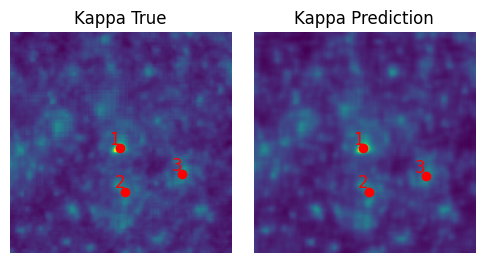

In [28]:
index =  25

prediction = y_pred[index].squeeze()
true_kappa = test_loader.dataset[index][1].numpy().squeeze()

plot_kappa(true_kappa, prediction, show_dpeaks=True)

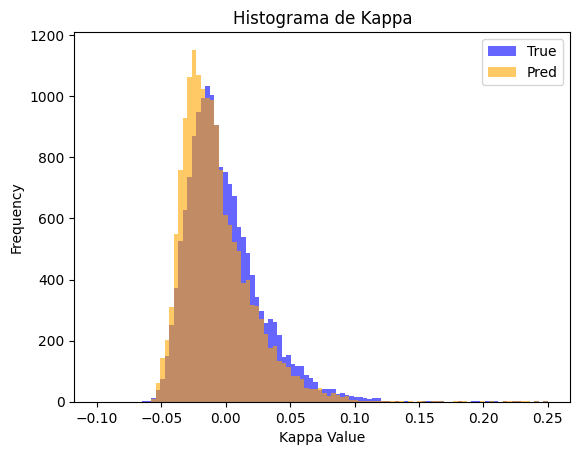

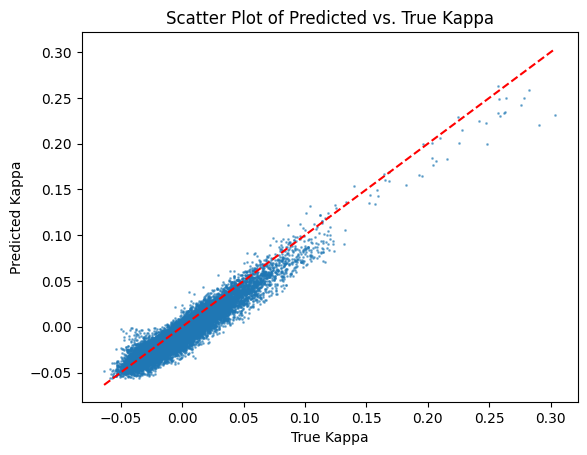

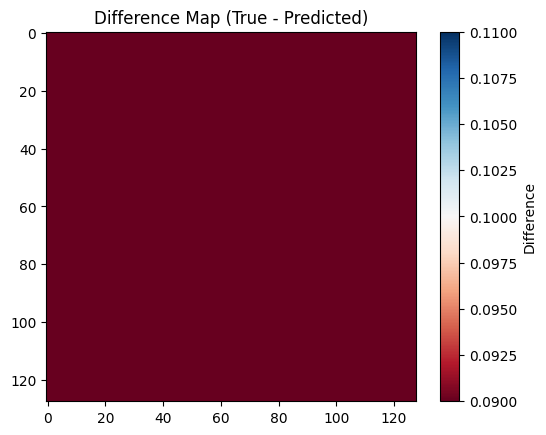

In [29]:
compare_kappa(true_kappa, prediction)

plot_scatter(true_kappa, prediction)

plot_difference_map(true_kappa, prediction)

metrics= ["lr", "dicee", "wmape", "dpeaks"]
history= checkpoint['history']
for met in metrics:
    plot_metric(met, history)

# Submission

## Setup

In [ ]:
TEST_DATASET_PATH = os.path.join('public_test', 'EPSILON')
PREDICTIONS_PATH = os.path.join('losfiducials')
TEST_MODEL_PATH = 'ResUnet_medium_dataset_0.001lr_model_50E.pth' # CHANGE!!
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# https://drive.google.com/file/d/1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx/view?usp=sharing
# test https://drive.google.com/file/d/1MtDSfDjhKnr5nYkSdmsPdlB3bXMVspfg/view?usp=sharing

data_zip = 'public_test.tar.gz'

if Path(data_zip).is_file():
    print("File already exists.")
else:
    import gdown

    file_id = '1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx'
    url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(url, data_zip, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx
From (redirected): https://drive.google.com/uc?id=1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx&confirm=t&uuid=0e34445d-4f76-4d7b-b769-7d8812c83e4f
To: /content/public_test.tar.gz
100%|██████████| 5.92G/5.92G [01:38<00:00, 60.0MB/s]


In [ ]:
!mkdir public_test
!tar -xf public_test.tar.gz -C public_test

## Model

In [ ]:
class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, x):
        return torch.from_numpy(x).float()

transform = v2.Compose([
    ToTensor()
])

In [ ]:
file_id = '1vmacPE2P7dmp6CE6qhcrut4e_rHZDyWv' #MODEL DRIVE ID CHANGE ACCORDINGLY IF NEEDED

url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1vmacPE2P7dmp6CE6qhcrut4e_rHZDyWv
From (redirected): https://drive.google.com/uc?id=1vmacPE2P7dmp6CE6qhcrut4e_rHZDyWv&confirm=t&uuid=d8623189-8059-4142-9a70-83b2d0f272b4
To: /content/ResUnet_medium_dataset_0.001lr_model_50E.pth
100%|██████████| 97.6M/97.6M [00:03<00:00, 30.0MB/s]


'ResUnet_medium_dataset_0.001lr_model_50E.pth'

In [ ]:
model_test = ResUnet(in_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)

checkpoint = torch.load(TEST_MODEL_PATH, weights_only=False, map_location=DEVICE)
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Predict

In [ ]:
def predict_step(model, epsilon, device):
    model.eval()
    with torch.inference_mode():
        epsilon = epsilon.to(device)
        y_hat = model(epsilon)
        y_hat_detached = y_hat.detach()
    return y_hat_detached

In [ ]:
if not os.path.exists(PREDICTIONS_PATH):
    os.makedirs(PREDICTIONS_PATH)

In [ ]:
epsilon_files = os.listdir(TEST_DATASET_PATH)

p_bar = tqdm(epsilon_files, total=len(epsilon_files), desc='')

for epsilon_filepath in p_bar:
    epsilon_data = np.load(os.path.join(TEST_DATASET_PATH, epsilon_filepath))
    epsilon_data_torch = transform(epsilon_data).unsqueeze(0)
    y_hat = predict_step(model_test, epsilon_data_torch, DEVICE)

    y_hat = y_hat.squeeze().cpu().numpy().astype(np.float16)
    np.save(os.path.join(PREDICTIONS_PATH, epsilon_filepath), y_hat)

100%|██████████| 76522/76522 [09:53<00:00, 128.90it/s]


## Plot Predictions

In [ ]:
def plot_prediction(prediction_filepath):
    prediction_image = np.load(prediction_filepath)

    plt.imshow(prediction_image)
    plt.axis('off')
    plt.title('Prediction')
    plt.show()

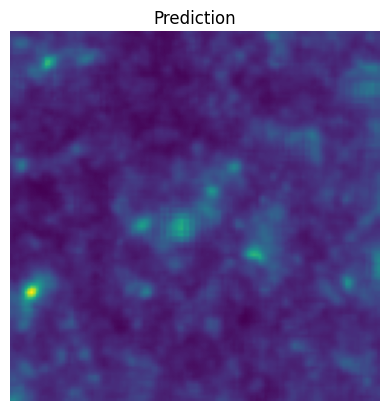

In [ ]:
prediction_filenames = os.listdir(PREDICTIONS_PATH)
prediction_idx = 55

prediction_filepath = os.path.join(PREDICTIONS_PATH, prediction_filenames[prediction_idx])
plot_prediction(prediction_filepath)

## Compress Predictions

In [ ]:
!7z a losfiducials_submission.zip losfiducials


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive:
  0M Scan           1413M 45056 Scan  losfiducials/                               1 folder, 76522 files, 2517267712 bytes (2401 MiB)

Creating archive: losfiducials_submission.zip

Items to compress: 76523

  0%      0% 138 + losfiducials/00923_00138.npy                                         0% 267 + losfiducials/00923_00268.npy                                         0% 418 + losfiducials/00923_00418.npy                                         0% 564 

## Upload to Drive if working in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

COLAB_PATH = '/content/drive/MyDrive/'
LOCAL_PATH = 'losfiducials_submission.zip'

shutil.copyfile(LOCAL_PATH, os.path.join(COLAB_PATH, LOCAL_PATH))

Mounted at /content/drive


'/content/drive/MyDrive/losfiducials.zip'